In [78]:
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 2.2em;
line-height:1.4em;
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
color: #7B68EE;
}

div.text_cell_render h3 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
color: #7B68EE;
font-weight: 900;
}

div.text_cell_render { /* Customize text cells */
font-family: 'Lato';
font-size:15.5px;
color: #404040;
line-height:1.4em;
}
.CodeMirror pre {font-family: 'Monaco'; font-size: 10pt;}
</style>
""")

## Table of contents
 
 1. [Introduction](#Introduction)
 
 2. [Required libraries](#Required-libraries)

 3. [Loading the datasets](#Step-2:-Checking-the-data)
 
 4. [Exploring_the_data](#EDA)
     * [Outliers!](#outliers)
     * [Checking normality](#normality)
     * [Missing Value Imputation](#missing) 
     * [Box Cox Transformation](#boxcox)
     * [Label-Encoding](#labelencoding)
     * [Categorical Variable Handling](#dummycoding)
     
 5. [Regression](#Step-5:-Classification)
 
    * [Cross-validation](#Cross-validation)
    * [Parameter tuning](#Parameter-tuning)
   
 6. [Conclusions](#Conclusions)

 7. [Acknowledgements](#Acknowledgements)

<a href ='Introduction'></a>
## Introduction
[[Go to Content]](#Table-of-contents)

<p>In this notebook, I intent to use the Kaggle Advance House Problem to predict the price of a house based on its features. 

Just based on my intuition, the first thing that comes to my mind is that houses with more square footage will be more costly than the ones with less square footage. When I think harder, I realize that a 1000sq ft house in Boston downtown is not the same price as a 1000sq ft house in Greater Boston area. The complexity of the problem lies in various factors interacting with one another.</p>

<p>In this notebook, my main focus is to analyze factors that contribute in estimating a price of a house. Below are the few factors that I think we play significant role in house predictions are below</p>
<li>Square Footage</li>
<li>Locality</li>
<li>Proximity to schools</li>
<li>No. of rooms</li>
<li>Amneties</li>



### Required Packages
[[Go to Content]](#Table-of-contents)

* **NumPy**: Provides a fast numerical array structure and helper functions.
* **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
* **scikit-learn**: The essential Machine Learning package in Python.
* **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
* **seaborn**: Advanced statistical plotting library.

In [79]:
# Loading the packages needed
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
print('package have been loaded...')

package have been loaded...


### Loading the train and test
[[Go to Content]](#Table-of-contents)

Here I preserve the Id column to be later used for test submission. Since it does not hold any value for training, I am removing this from both test and train sets

In [80]:
# Loading the datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
# Saving the train id and the test id
train_id = train['Id']
test_id = test['Id']
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)
print('Id field has been dropped')
print('Trainset Shape', train.shape)
print('Train/Test are loaded...')

Id field has been dropped
Trainset Shape (1460, 80)
Train/Test are loaded...


In [81]:
# Viewing the dataset
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Detecting Outliers!

In order to detect outliers, we will first plot heatmaps to find some good correlations with the SalePrice and then see which features have high correlation

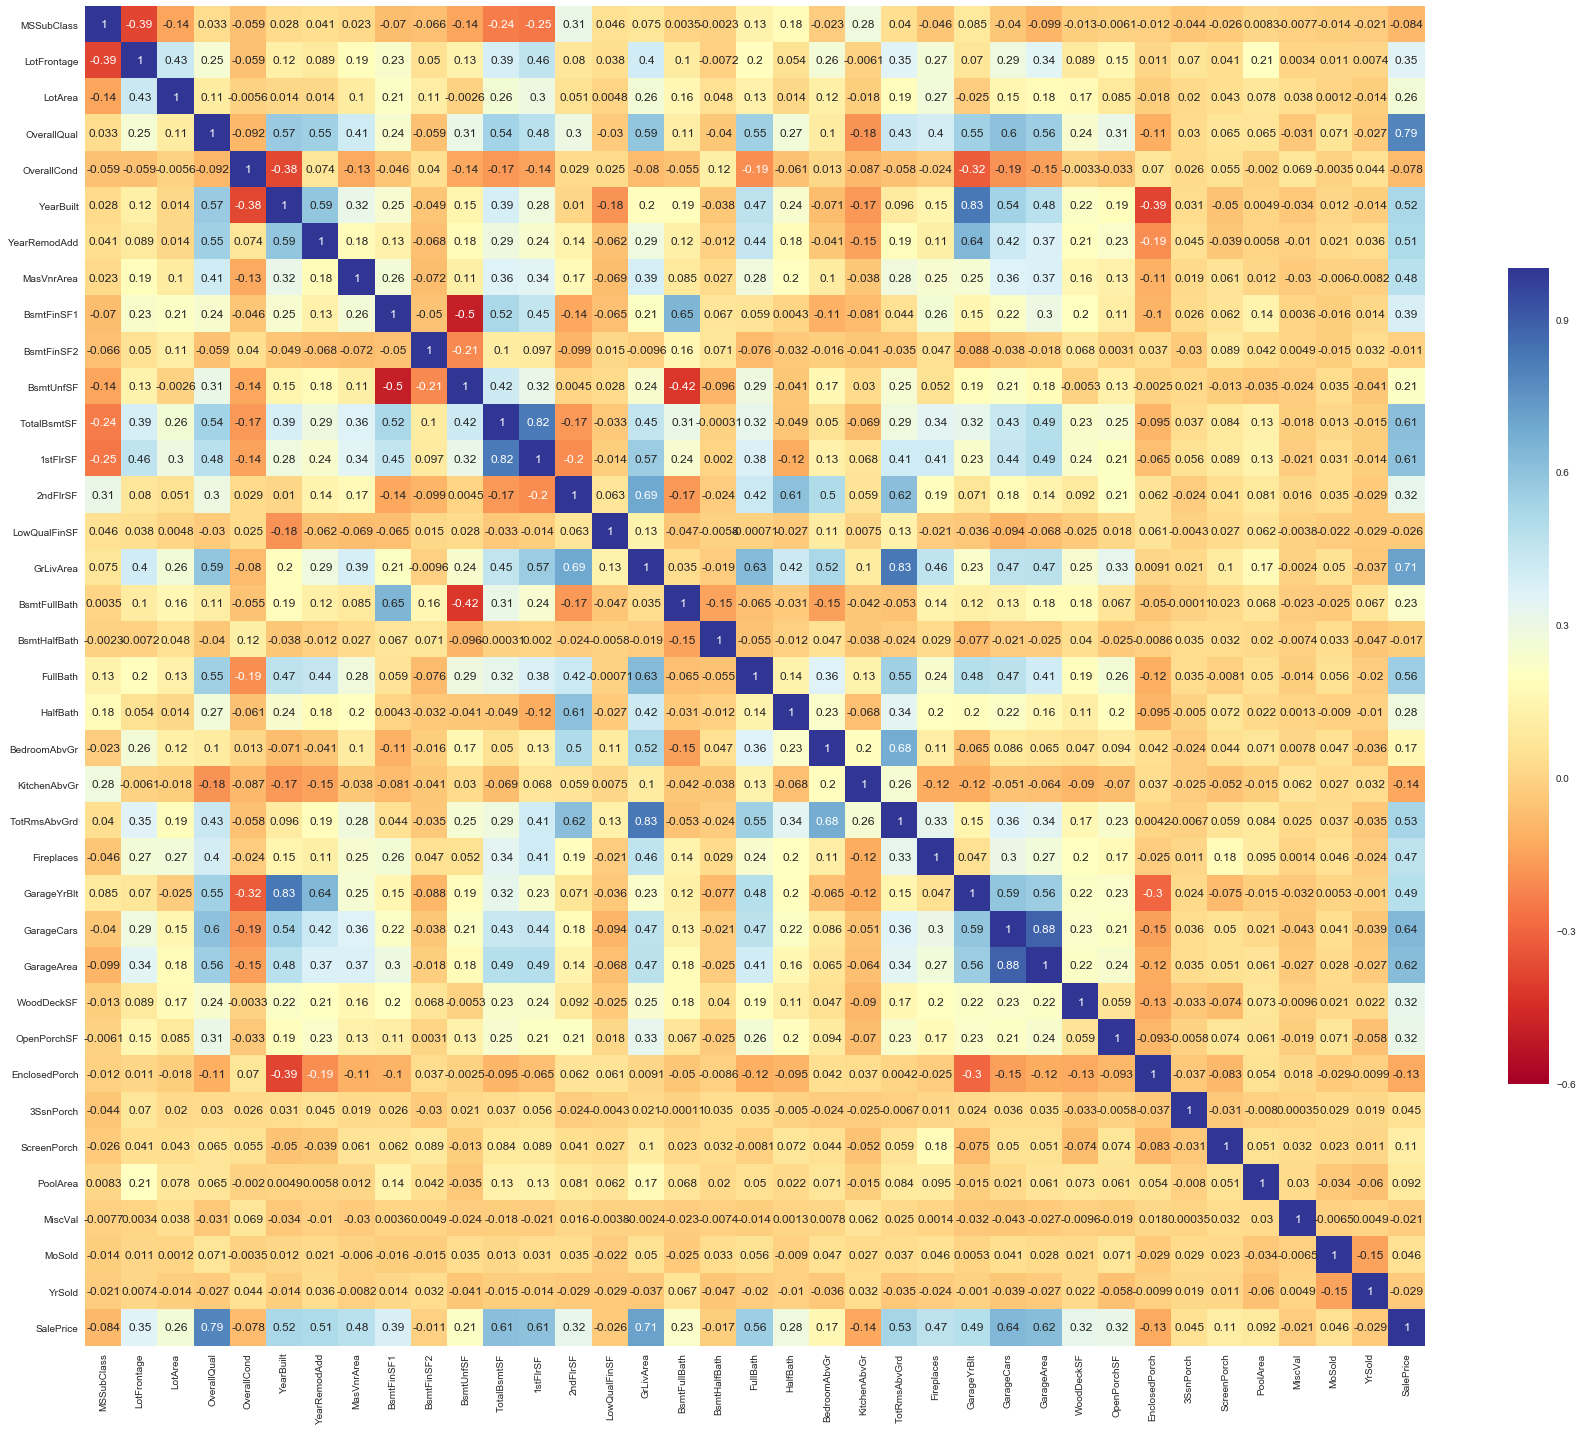

In [82]:
corr = train.corr()
plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(150, 250, as_cmap=True)
sns.heatmap(corr, cmap="RdYlBu", vmax=1, vmin=-0.6, center=0.2, square=True, \
            linewidths=0, cbar_kws={"shrink": .5}, annot = True);
plt.show()

<p>From here I gather that 4 most highly correlated features are:</p>

* **OverallQual**: Overall material and finish quality
* **GrLivArea**:  Above grade (ground) living area square feet
* **GarageCars**:  Size of garage in car capacity
* **GarageArea**:  Size of garage in square feet
* **TotalBsmtSF**: Total square feet of basement area
* **1stFlrSF**: First Floor square feet

In [83]:
# Finding the most correlated features to SalesPrice
corr_features = (corr['SalePrice'] >= 0.6) | (corr['SalePrice'] <= -0.6) 
corr_features = corr_features[corr_features == True].index

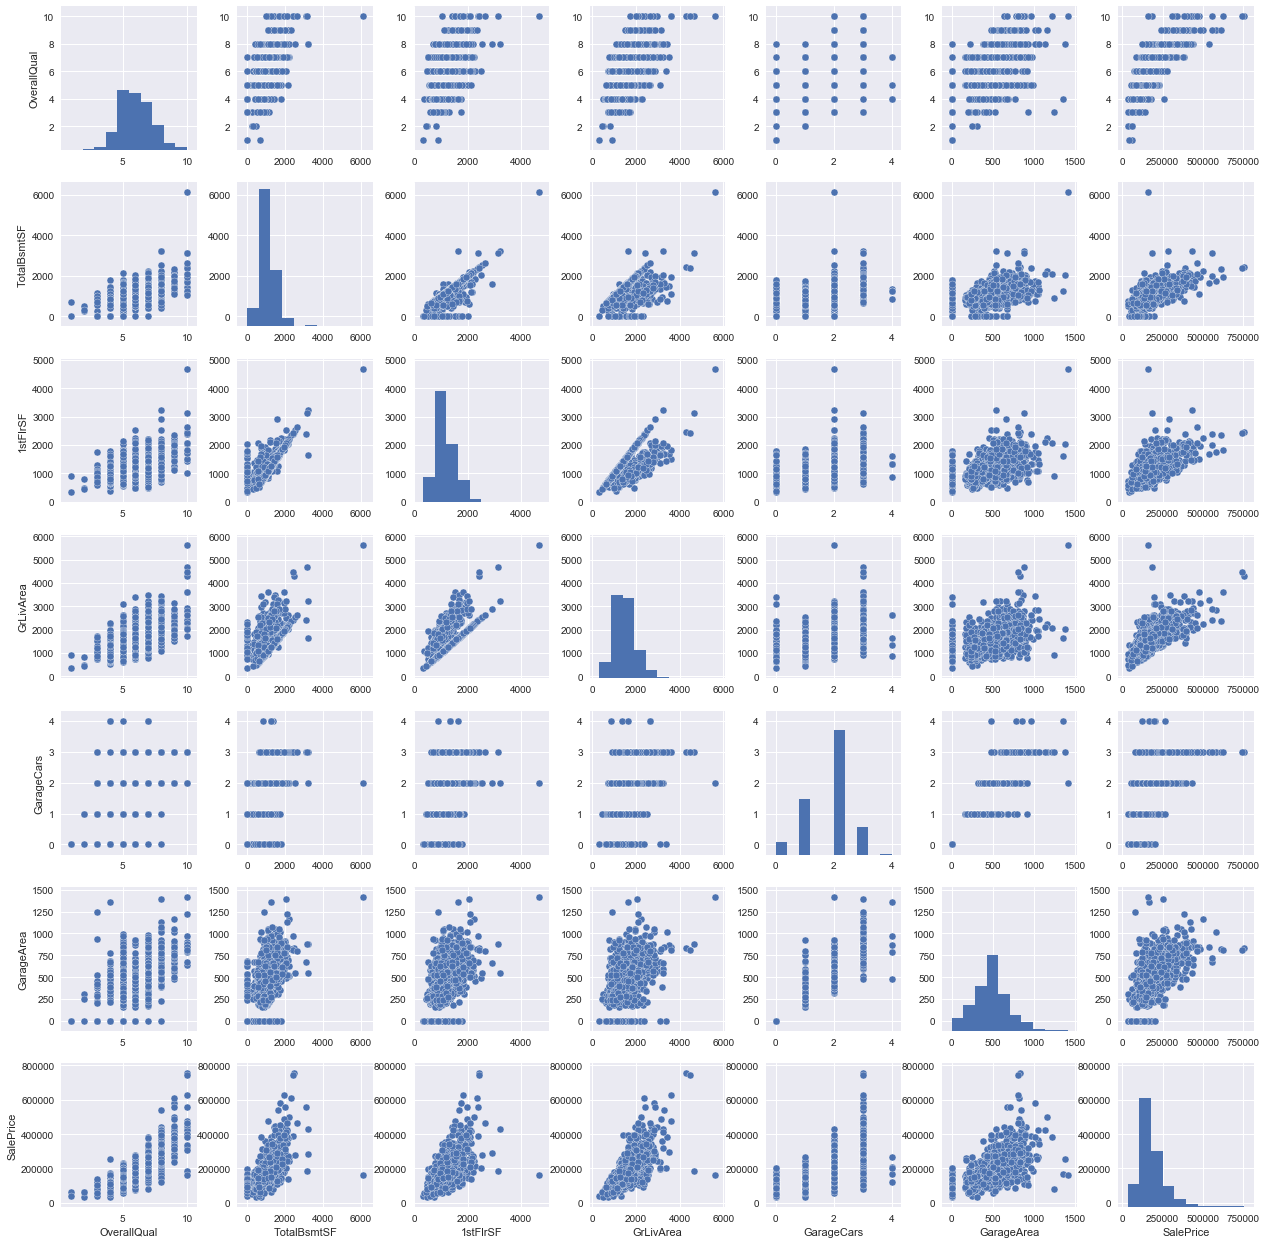

In [84]:
# Pairplots
sns.set()
sns.pairplot(train[corr_features])
plt.show();

I am just looking the bivariate analysis of SalePrice and other features.

For an extremly cheap house price of worth 160K, we notice that both TotalBsmtSF and 1stFlrSF is 6000 SF and 5000 SF. This seems an outlier. So at this point, we will remove this data point.

In [85]:
train[train['TotalBsmtSF'] > 6000]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [86]:
# Deleting the outlier
train.drop(train.index[1298], inplace=True)

### Seeing my buddy... The SalesPrice

In the below snippet, we want to check how SalesPrice is distributed. Most machine learning algorithm work under the assumption that the data is normally distributed. Here we will check the distribution of SalesPrice. If the distribution appears skewed, we will transform the data.

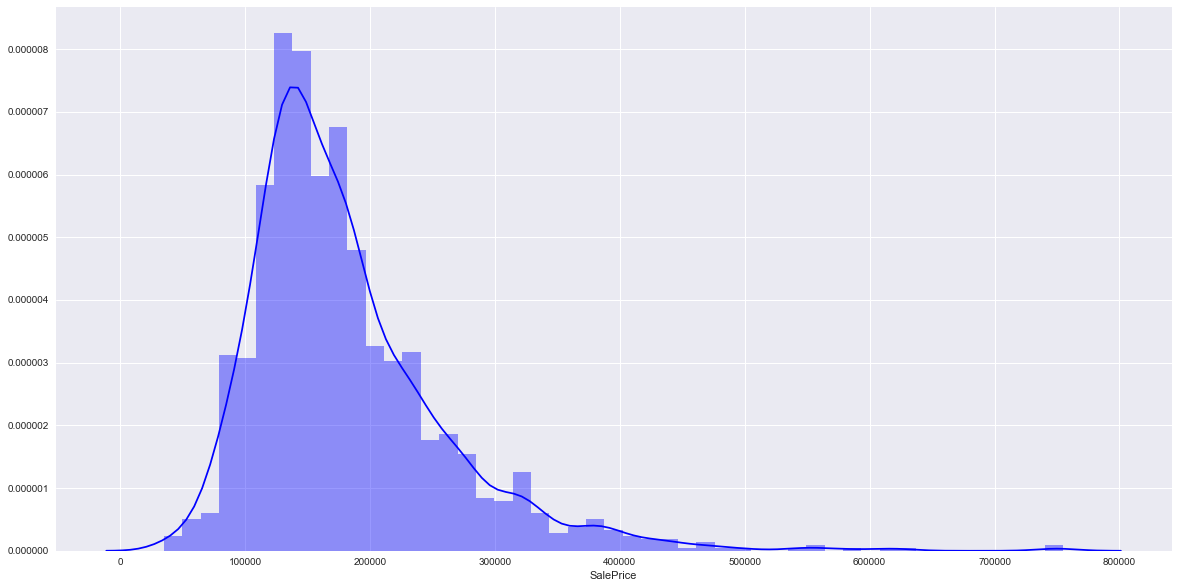

In [87]:
# Distribution
plt.subplots(figsize =(20, 10))
sns.distplot(train['SalePrice'], color ='blue')
plt.show()

We observe right skwedness in the Target Variable. To fix it, we will log transform it. If you notice then the distribution also touches the value of 0 and hence log(0) will be undefined. In order to avoid that, we will take log(SalesPrice+1)

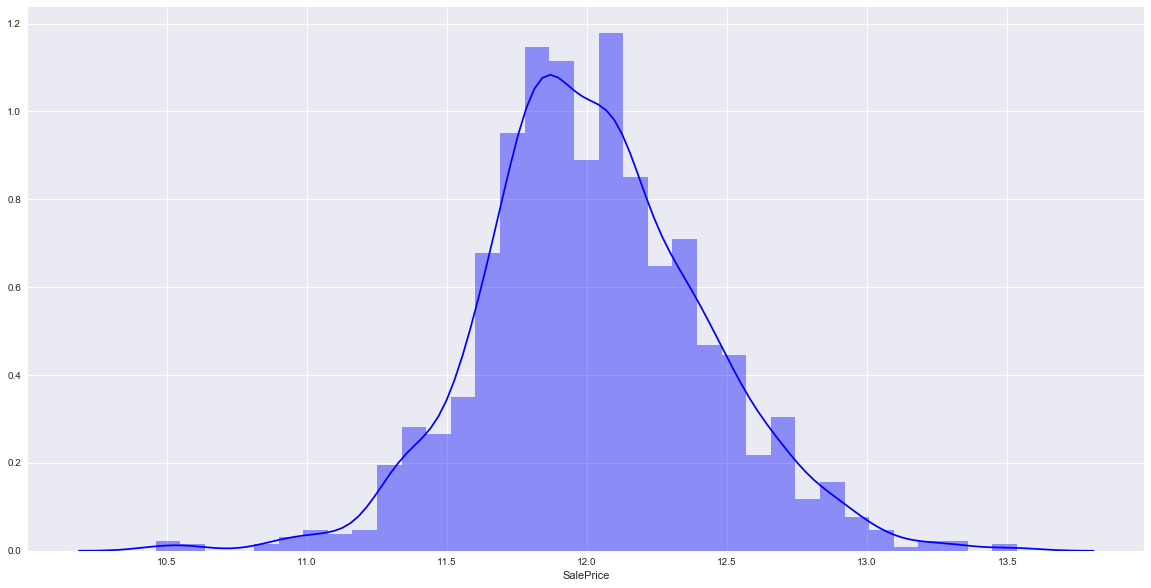

In [88]:
# log transformation
train['SalePrice'] = (train.SalePrice+1).apply(np.log)

# Rechecking the distribution now
plt.subplots(figsize =(20, 10))
sns.distplot(train['SalePrice'], color ='blue')
plt.show()

In [89]:
# detecting the outliers

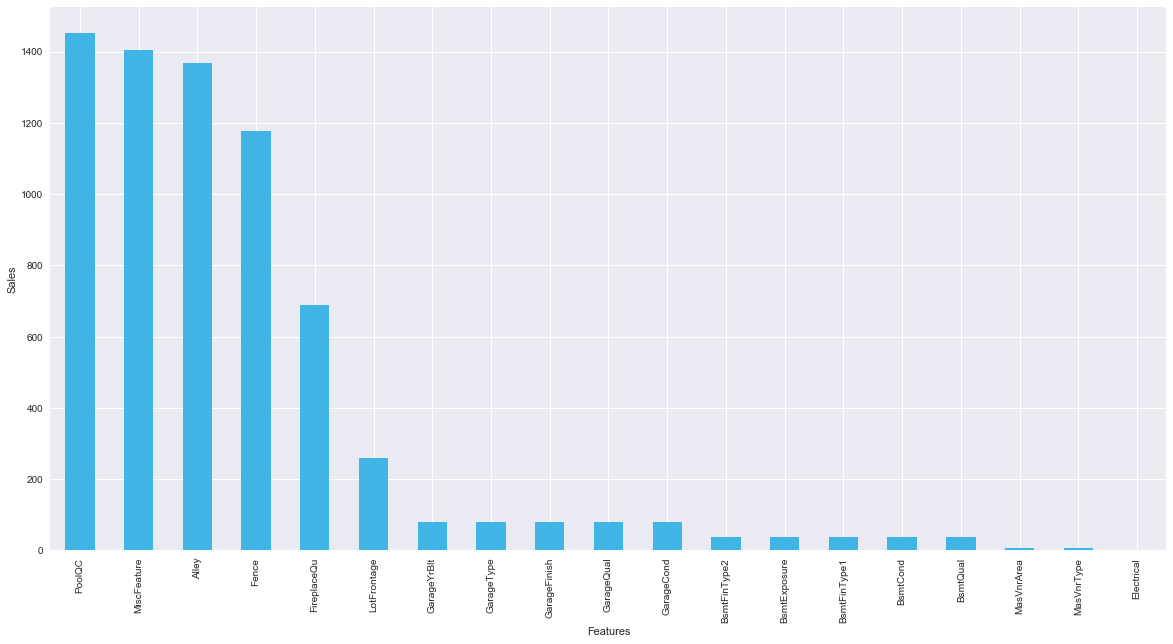

In [90]:
count_miss_train = train.isnull().sum()
count_miss_train = count_miss_train[count_miss_train!=0].sort_values(ascending=False)

plt.subplots(figsize =(20, 10))
count_miss_train.plot(kind='bar', color='#40b4e5')
plt.xlabel('Features')
plt.ylabel('Sales')
plt.show()

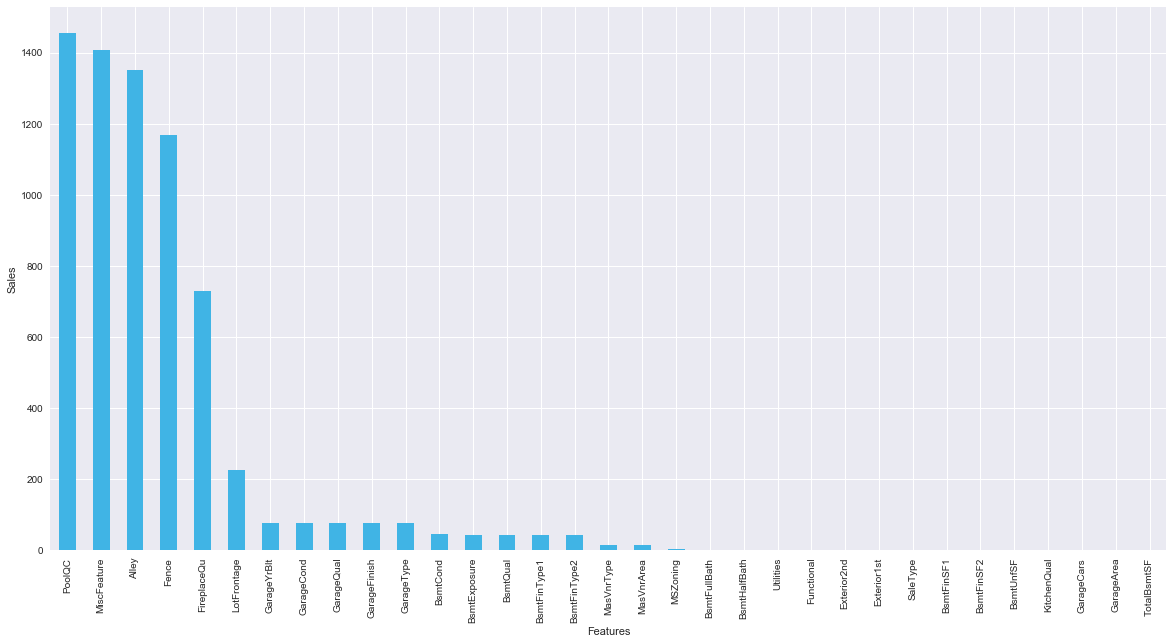

In [91]:
# Also, analyzing the missing data in testing set
count_miss_test = test.isnull().sum()
count_miss_test = count_miss_test[count_miss_test!=0].sort_values(ascending=False)

plt.subplots(figsize =(20, 10))
count_miss_test.plot(kind='bar', color='#40b4e5')
plt.xlabel('Features')
plt.ylabel('Sales')
plt.show()

<p> For values which have lesser missing values, we will impute either by frequency (mode) if the feature is categorical, else, with mean / median if it is non categorical. For features with higher number of missing values, we will remove them</p>

<li>PoolQC - Pool Quality (can be removed)</li>
<li>MiscFeature: Miscellaneous feature not covered in other categories (can be removed</li>

In [92]:
# Combining the test and train data
train['Type'] = 'Train'
test['SalePrice'] = 0
test['Type'] = 'Test'
housing = train.append(test)

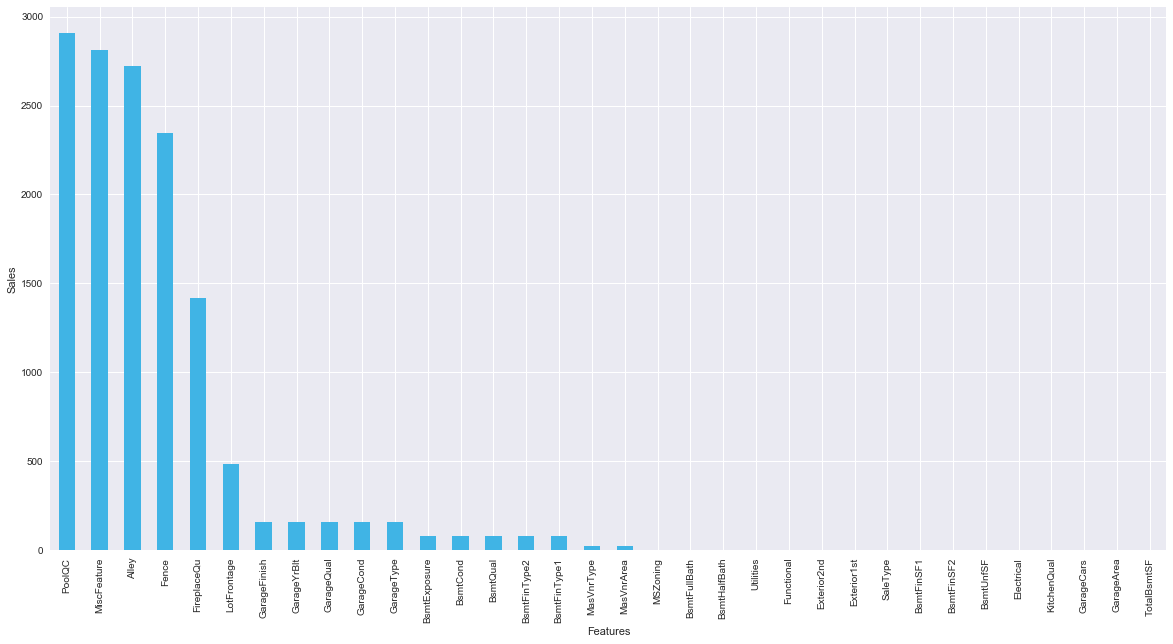

In [93]:
housing_miss = housing.isnull().sum()
housing_miss = housing_miss[housing_miss!=0].sort_values(ascending=False)

plt.subplots(figsize =(20, 10))
housing_miss.plot(kind='bar', color='#40b4e5')
plt.xlabel('Features')
plt.ylabel('Sales')
plt.show()

In [94]:
# Imputing with mode for below features
GarageQual_mode = housing[housing.GarageQual.notnull()]['GarageQual'].mode()[0]
housing['GarageQual'].fillna(GarageQual_mode,inplace=True)

GarageYrBlt_mode = housing[housing.GarageYrBlt.notnull()]['GarageYrBlt'].mode()[0]
housing['GarageYrBlt'].fillna(GarageYrBlt_mode,inplace=True)

GarageCond_mode = housing[housing.GarageCond.notnull()]['GarageCond'].mode()[0]
housing['GarageCond'].fillna(GarageCond_mode,inplace=True)

GarageFinish_mode = housing[housing.GarageFinish.notnull()]['GarageFinish'].mode()[0]
housing['GarageFinish'].fillna(GarageFinish_mode,inplace=True)

GarageType_mode = housing[housing.GarageType.notnull()]['GarageType'].mode()[0]
housing['GarageType'].fillna(GarageType_mode,inplace=True)

BsmtExposure_mode = housing[housing.BsmtExposure.notnull()]['BsmtExposure'].mode()[0]
housing['BsmtExposure'].fillna(BsmtExposure_mode,inplace=True)

BsmtCond_mode = housing[housing.BsmtCond.notnull()]['BsmtCond'].mode()[0]
housing['BsmtCond'].fillna(BsmtCond_mode,inplace=True)

BsmtQual_mode = housing[housing.BsmtQual.notnull()]['BsmtQual'].mode()[0]
housing['BsmtQual'].fillna(BsmtQual_mode,inplace=True)

BsmtFinType2_mode = housing[housing.BsmtFinType2.notnull()]['BsmtFinType2'].mode()[0]
housing['BsmtFinType2'].fillna(BsmtFinType2_mode,inplace=True)

BsmtFinType1_mode = housing[housing.BsmtFinType1.notnull()]['BsmtFinType1'].mode()[0]
housing['BsmtFinType1'].fillna(BsmtFinType1_mode,inplace=True)

MasVnrArea_mode = housing[housing.MasVnrArea.notnull()]['MasVnrArea'].median()
housing['MasVnrArea'].fillna(MasVnrArea_mode,inplace=True)

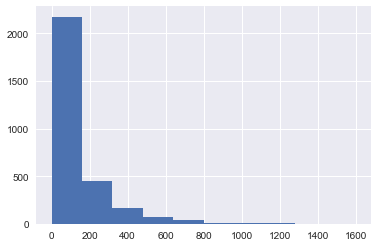

In [95]:
housing[housing.MasVnrArea.notnull()]['MasVnrArea'].hist()
plt.show()

Based on the histogram, we will keep the value as 0

In [96]:
MasVnrType_mode = housing[housing.MasVnrType.notnull()]['MasVnrType'].mode()[0]
housing['MasVnrType'].fillna(MasVnrType_mode,inplace=True)

BsmtCond_mode = housing[housing.BsmtCond.notnull()]['BsmtCond'].mode()[0]
housing['Electrical'].fillna(BsmtCond_mode,inplace=True)

BsmtQual_mode = housing[housing.BsmtQual.notnull()]['BsmtQual'].mode()[0]
housing['BsmtUnfSF'].fillna(BsmtQual_mode,inplace=True)

BsmtHalfBath_mode = housing[housing.BsmtHalfBath.notnull()]['BsmtHalfBath'].mode()[0]
housing['BsmtHalfBath'].fillna(BsmtHalfBath_mode,inplace=True)

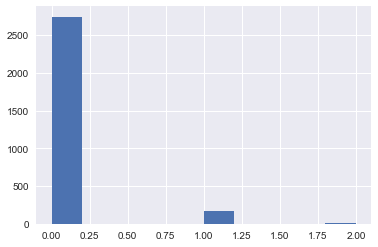

In [97]:
housing[housing.BsmtHalfBath.notnull()]['BsmtHalfBath'].hist()
plt.show()

Keeping this value as 0

In [98]:
BsmtFinType1_mode = housing[housing.BsmtFinType1.notnull()]['BsmtFinType1'].mode()[0]
housing['BsmtFinType1'].fillna(BsmtFinType1_mode,inplace=True)

Utilities_mode = housing[housing.Utilities.notnull()]['Utilities'].mode()[0]
housing['Utilities'].fillna(Utilities_mode,inplace=True)

Functional_mode = housing[housing.Functional.notnull()]['Functional'].mode()[0]
housing['Functional'].fillna(Functional_mode,inplace=True)

BsmtFinType1_mode = housing[housing.BsmtFinType1.notnull()]['BsmtFinType1'].mode()[0]
housing['BsmtFinType1'].fillna(BsmtFinType1_mode,inplace=True)

Exterior1st_mode = housing[housing.Exterior1st.notnull()]['Exterior1st'].mode()[0]
housing['Exterior1st'].fillna(Exterior1st_mode,inplace=True)

Exterior2nd_mode = housing[housing.Exterior2nd.notnull()]['Exterior2nd'].mode()[0]
housing['Exterior2nd'].fillna(Exterior2nd_mode,inplace=True)

TotalBsmtSF_mode = housing[housing.TotalBsmtSF.notnull()]['TotalBsmtSF'].median()
housing['TotalBsmtSF'].fillna(TotalBsmtSF_mode,inplace=True)

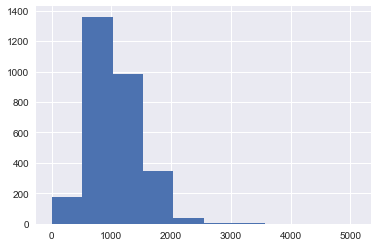

In [99]:
housing[housing.TotalBsmtSF.notnull()]['TotalBsmtSF'].hist()
plt.show()

Replacing with the median in this case.

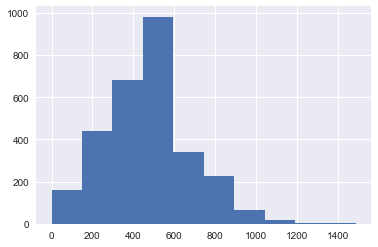

In [100]:
housing[housing.GarageArea.notnull()]['GarageArea'].hist()
plt.show()

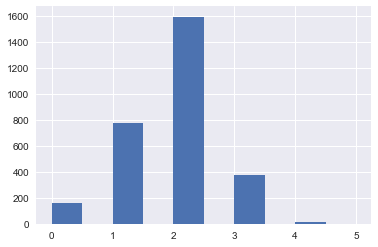

In [101]:
housing[housing.GarageCars.notnull()]['GarageCars'].hist()
plt.show()

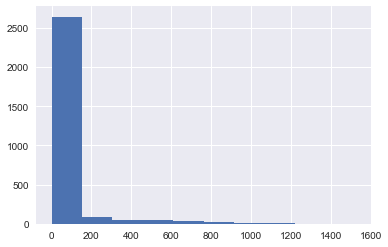

In [102]:
housing[housing.BsmtFinSF2.notnull()]['BsmtFinSF2'].hist()
plt.show()

In [103]:
GarageArea_mode = housing[housing.GarageArea.notnull()]['GarageArea'].median()
housing['GarageArea'].fillna(GarageArea_mode,inplace=True)

GarageCars_mode = housing[housing.GarageCars.notnull()]['GarageCars'].median()
housing['GarageCars'].fillna(GarageCars_mode,inplace=True)

SaleType_mode = housing[housing.SaleType.notnull()]['SaleType'].mode()[0]
housing['SaleType'].fillna(SaleType_mode,inplace=True)

KitchenQual_mode = housing[housing.KitchenQual.notnull()]['KitchenQual'].mode()[0]
housing['KitchenQual'].fillna(KitchenQual_mode,inplace=True)

BsmtFinSF2_mode = housing[housing.BsmtFinSF2.notnull()]['BsmtFinSF2'].median()
housing['BsmtFinSF2'].fillna(BsmtFinSF2_mode,inplace=True)

BsmtFinSF1_mode = housing[housing.BsmtFinSF1.notnull()]['BsmtFinSF1'].median()
housing['BsmtFinSF1'].fillna(BsmtFinSF1_mode,inplace=True)

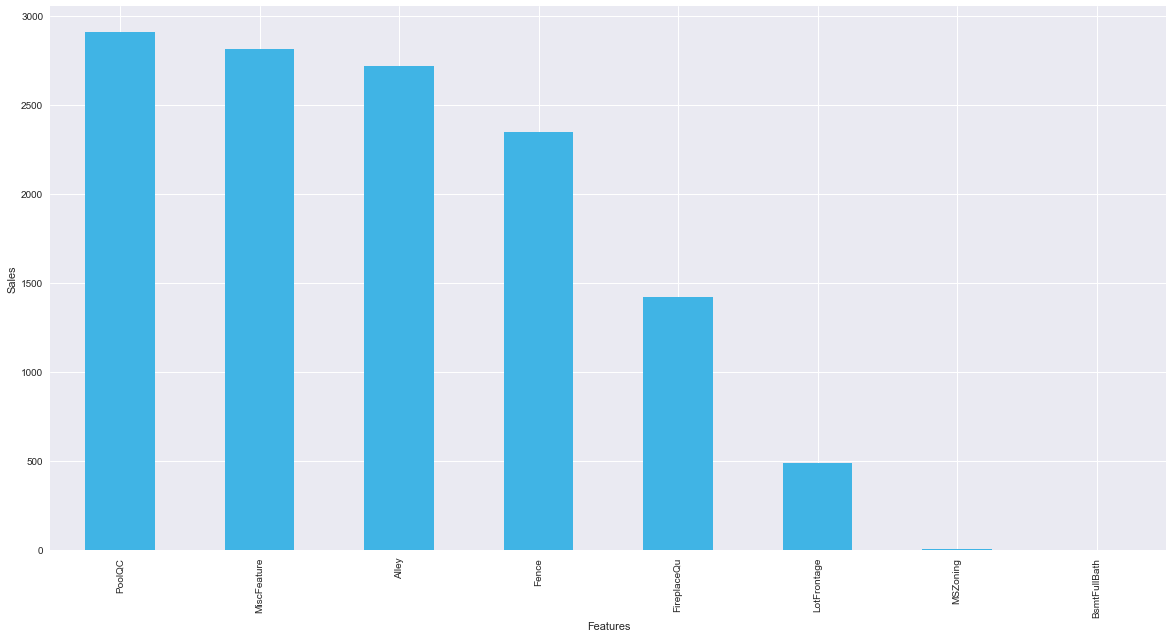

In [104]:
# Checking the missing values now
housing_miss = housing.isnull().sum()
housing_miss = housing_miss[housing_miss!=0].sort_values(ascending=False)

plt.subplots(figsize =(20, 10))
housing_miss.plot(kind='bar', color='#40b4e5')
plt.xlabel('Features')
plt.ylabel('Sales')
plt.show()

In [105]:
missing_cutoff = round(housing.shape[0] * 0.3,0)

feat_miss_cutoff = housing.isnull().sum()[housing.isnull().sum() > missing_cutoff].index[:].tolist()

housing.drop(feat_miss_cutoff, axis=1, inplace=True)

In [106]:
housing.isnull().sum()

MSSubClass         0
MSZoning           4
LotFrontage      486
LotArea            0
Street             0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         0
MasVnrArea         0
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual           0
BsmtCond           0
                ... 
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
KitchenQual        0
TotRmsAbvGrd       0
Functional         0
Fireplaces         0
GarageType         0
GarageYrBlt        0
GarageFinish       0
GarageCars         0
GarageArea         0
GarageQual         0
GarageCond         0
PavedDrive   

In [107]:
feat_miss_cutoff

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

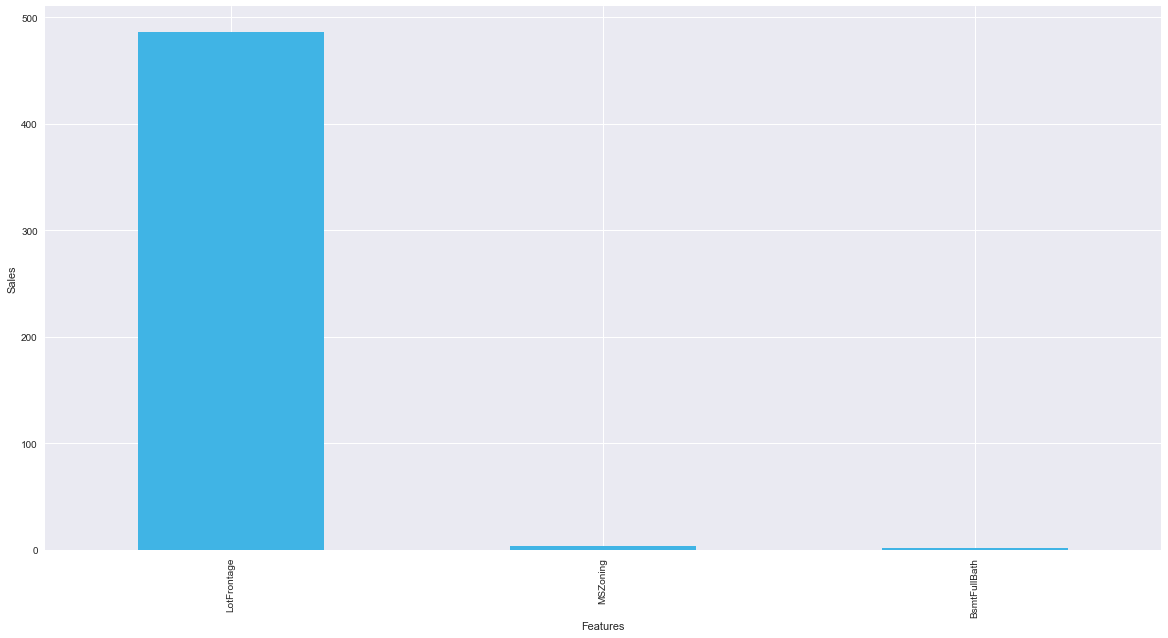

In [108]:
# Checking the missing values now
housing_miss = housing.isnull().sum()
housing_miss = housing_miss[housing_miss!=0].sort_values(ascending=False)

plt.subplots(figsize =(20, 10))
housing_miss.plot(kind='bar', color='#40b4e5')
plt.xlabel('Features')
plt.ylabel('Sales')
plt.show()

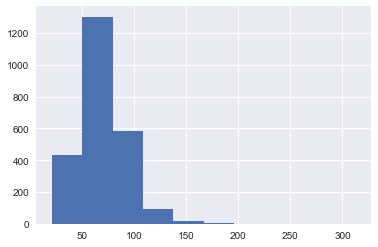

In [109]:
housing[housing.LotFrontage.notnull()]['LotFrontage'].hist()
plt.show()

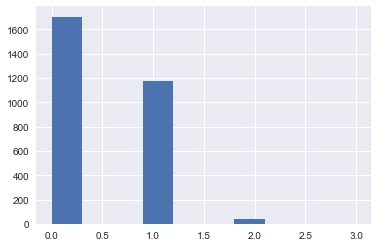

In [110]:
housing[housing.BsmtFullBath.notnull()]['BsmtFullBath'].hist()
plt.show()

In [111]:
LotFrontage_mode = housing[housing.LotFrontage.notnull()]['LotFrontage'].median()
housing['LotFrontage'].fillna(LotFrontage_mode,inplace=True)

MSZoning_mode = housing[housing.MSZoning.notnull()]['MSZoning'].mode()[0]
housing['MSZoning'].fillna(MSZoning_mode,inplace=True)

BsmtFullBath_mode = housing[housing.BsmtFullBath.notnull()]['BsmtFullBath'].median()
housing['BsmtFullBath'].fillna(BsmtFullBath_mode,inplace=True)

In [112]:
# Checking the missing values now
housing_miss = housing.isnull().sum()
housing_miss = housing_miss[housing_miss!=0].sort_values(ascending=False)
if (housing_miss.empty):
    print('All missing values treated!')
else:
    print('Error needs to be investigated!')

All missing values treated!


In [113]:
# Splitting the data again into train and test
train = housing[housing['Type']=='Train']
test = housing[housing['Type']=='Test']
train.drop(['Type'], axis=1, inplace=True)
test.drop(['Type'], axis=1, inplace=True)
test.drop(['SalePrice'], axis=1, inplace=True)

### Exploratory Data Analysis

[[Go to Content]](#Table-of-contents)

<p>Here I will on three things:</p>
* Correlation Analysis
* Checking distribution of the features

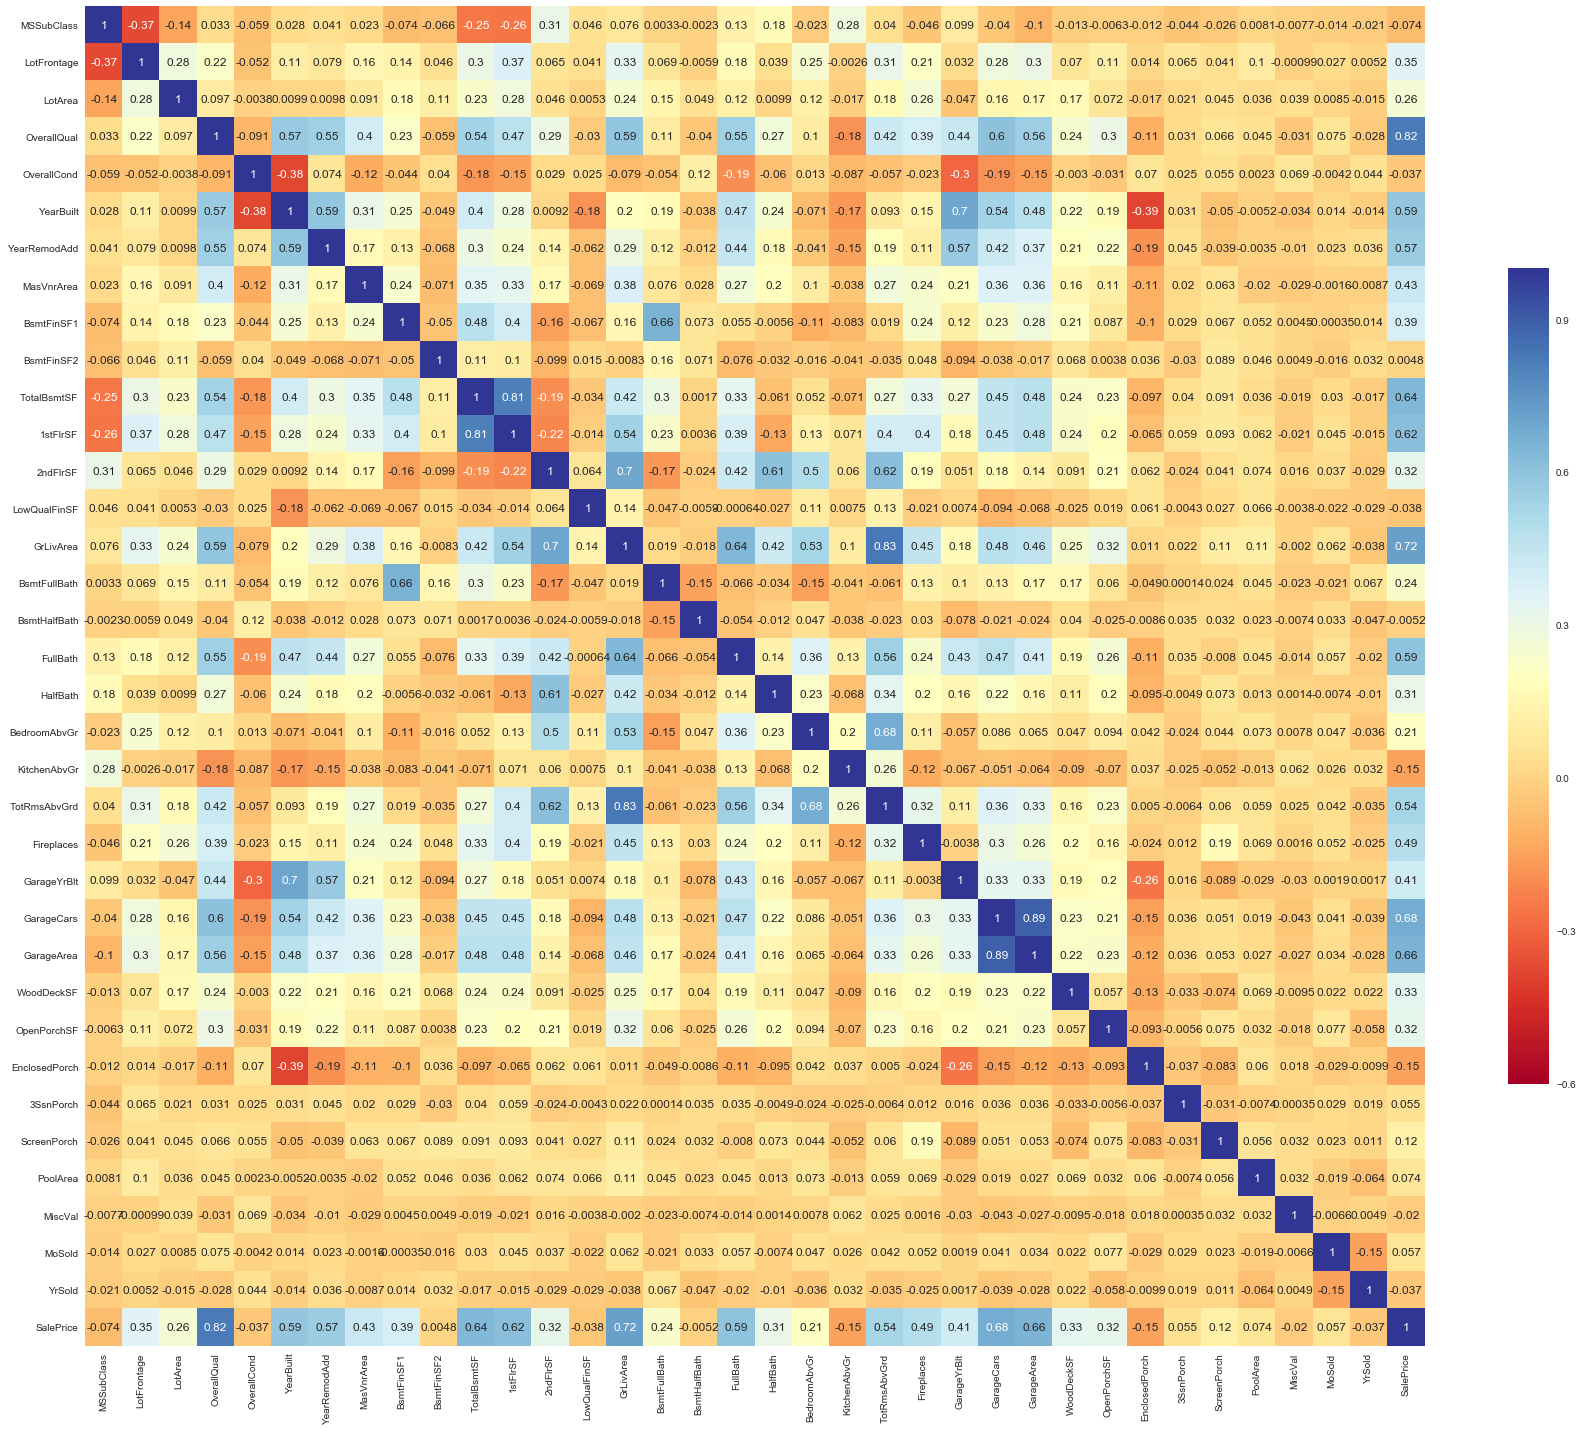

In [114]:
corr = train.corr()
plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(150, 250, as_cmap=True)
sns.heatmap(corr, cmap="RdYlBu", vmax=1, vmin=-0.6, center=0.2, square=True, \
            linewidths=0, cbar_kws={"shrink": .5}, annot = True);
plt.show()

<p>From here I gather that 4 most highly correlated features are:</p>

* **OverallQual**: Overall material and finish quality
* **GrLivArea**:  Above grade (ground) living area square feet
* **GarageCars**:  Size of garage in car capacity
* **GarageArea**:  Size of garage in square feet
* **TotalBsmtSF**: Total square feet of basement area
* **1stFlrSF**: First Floor square feet



In the next sections, we will perform data transformation which include:
* Label Encoding ordinal features
* Normalizing numerical features
* Creating dummy values for categorical features

Assessing each feature seperately:
'1stFlrSF', --> Continous
'2ndFlrSF', --> Continous
'3SsnPorch', --> Continuous
'BedroomAbvGr', --> Discrete
'BldgType', --> Nominal
'BsmtCond', --> Ordinal
'BsmtExposure', --> Ordinal
'BsmtFinSF1', --> Continuous
'BsmtFinSF2', --> Continuous
'BsmtFinType1', = Ordinal
'BsmtFinType2', = Ordinal
'BsmtFullBath', = Discrete
'BsmtHalfBath', = Discrete
'BsmtQual', = Ordinal
'BsmtUnfSF', = Continuous
'CentralAir', = Nominal
'Condition1', = Nominal
'Condition2', = Nominal
'Electrical', = Ordinal
'EnclosedPorch', = Continuous
'ExterCond', = Ordinal
'ExterQual', = Ordinal
'Exterior1st', = Nominal
'Exterior2nd', = Nominal
'Fireplaces', = Discrete
'Foundation', 
'FullBath', 
'Functional',
'GarageArea', 
'GarageCars',
'GarageCond',
'GarageFinish', 
'GarageQual', 
'GarageType', 'GarageYrBlt',
'GrLivArea', 'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle',
'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope', 'LotArea',
'LotConfig', 'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass',
'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscVal', 'MoSold',
'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
'PavedDrive', 'PoolArea', 'RoofMatl', 'RoofStyle', 'SaleCondition',
'SalePrice', 'SaleType', 'ScreenPorch', 'Street', 'TotRmsAbvGrd',
'TotalBsmtSF', 'Utilities', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd',
'YrSold'

Phew!!!... i am tired now

In [115]:
train.shape

(1459, 75)

In [126]:
df.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,type
0,856,854,0,3,1Fam,3,No,706.0,0.0,GLQ,...,0,Pave,8,856.0,AllPub,0,2003,2003,2008,train
1,1262,0,0,3,1Fam,3,Gd,978.0,0.0,ALQ,...,0,Pave,6,1262.0,AllPub,298,1976,1976,2007,train
2,920,866,0,3,1Fam,3,Mn,486.0,0.0,GLQ,...,0,Pave,6,920.0,AllPub,0,2001,2002,2008,train
3,961,756,0,3,1Fam,1,No,216.0,0.0,ALQ,...,0,Pave,7,756.0,AllPub,0,1915,1970,2006,train
4,1145,1053,0,4,1Fam,3,Av,655.0,0.0,GLQ,...,0,Pave,9,1145.0,AllPub,192,2000,2000,2008,train


In [120]:
df.columns

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BldgType',
       'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF',
       'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'EnclosedPorch',
       'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fireplaces',
       'Foundation', 'FullBath', 'Functional', 'GarageArea', 'GarageCars',
       'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt',
       'GrLivArea', 'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle',
       'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope', 'LotArea',
       'LotConfig', 'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass',
       'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'RoofMatl', 'RoofStyle', 'SaleCondition',
       'SalePrice', 'S

In [117]:
# Before I do any manipulation, I am going to combine the train and testing set
train['type'] = 'train'
test['type'] = 'test'
test['SalePrice'] = 0
df = train.append(test)

In [125]:
# Converting all ordinal features to label encoders
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for feature in ['']:    
    le.fit(df[item])
    df[item] = le.transform(df[item]) 

In [68]:
scaler = MinMaxScaler(0,1)
scaler.fit_transform(train[['LotFrontage', 'LotArea']].values.astype('float32'))

TypeError: 'int' object is not subscriptable

In [60]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,12.247699
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,12.109016
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,12.317171
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,11.849405
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,12.429220


In [47]:
# Label Encoding
train['MSZoning'].unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [113]:
# Create arrays for the features and the response variable
y = train['SalePrice'].values
X = train.drop('SalePrice', axis=1).values

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [118]:
#Let's go instantiate, fit and predict. 
gbrt=GradientBoostingRegressor(n_estimators=100) 
gbrt.fit(X_train, y_train) 
y_pred=gbrt.predict(X_test)

In [120]:
print ("Feature Importances") 
print (gbrt.feature_importances_)
#Let's print the R-squared value for train/test. This explains how much of the variance in the data our model is #able to decipher. 
print ("R-squared for Train: %.2f" %gbrt.score(X_train, y_train) )
print ("R-squared for Test: %.2f" %gbrt.score(X_test, y_test) )

Feature Importances
[0.07044663 0.12578241 0.07206629 0.0604043  0.02035992 0.08947851
 0.10326478 0.03664672 0.15906415 0.01838418 0.03295429 0.0620821
 0.05641846 0.03870603 0.05394123]
R-squared for Train: 0.95
R-squared for Test: 0.87
